# Focus Area 1 — Ground Observations Monitoring &amp; QC
**Core Objective**: To equip NMHS participants with tools for quality-controlling ground station
data and validating it against satellite products, enabling identification of network issues and
building confidence in observational networks.

Require 2 files
- The Metadata file: TAHMO_Metadata.csv
- The TAHMO data file: TAHMO_data.csv

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>lat</th>
            <th>lon</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Required Dependencies

Steps Breakdown
- Step 1: Setting up environment and Authentication

- Data Extraction and Loading
    - Step2: Select your region of interest to extract the satellite data
    - Step3: Filter and visualise the metadata for the region of interest plus the precipitation data extraction
    - Step4: CHIRPS data extraction

- Data Processing and QC

    - Step5: Load the extracted data (Ground + Satellite)
    - Step6: Look at the data (Range, missing)
    - Step7: Aggregate the Ground data to Pentads
    - Step8: Build CHIRPS Nearest data from ground station AND visual comparison
    - Step9: Compute per station score visualising the high/medium/low scores

For any questions or concerns reach out please send an email to kaburiaaustin1@tahmo.org

In [3]:
# @title Step 1a: Setting up environment installing required Dependencies
# @markdown This cell installs the required dependencies for the workshop. It may take a few minutes <br>
# @markdown If you encounter any errors, please restart the runtime and try again. <br>
# @markdown If the error persists, please seek help.


print("Installing required dependencies...")
!pip install git+https://github.com/kaburia/NOAA-workshop.git > /dev/null 2>&1

!jupyter nbextension enable --py widgetsnbextension

# check there was no error
import sys
if not sys.argv[0].endswith("kernel_launcher.py"):
    print("❌ Errors occurred during installation. Please restart the runtime and try again.")
else:
    print("✅ Dependencies installed successfully.")

print("Importing required libraries...")
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel

# import os
# os.chdir('NOAA-workshop')

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data, plot_xarray_data2
from google.colab import drive

%matplotlib inline

print("✅ Libraries imported successfully.")

Installing required dependencies...
✅ Dependencies installed successfully.
Importing required libraries...
✅ Libraries imported successfully.


In [4]:
# @title ### Step 1b: Authentication Step
# @markdown This step is used to authenticate you as a user and there will be two popups that will be doing this.
# @markdown 1. **Authentication to Google Drive** - This is where we shall be loading the data after we have extracted it
# @markdown 2. **Authentication to Google Earth Engine** - This will be used to extract the CHIRPS data and any other satellite product we shall be extracting in the future.
# @markdown Please check your email we shared an invitation to our Google Cloud Project that we shall be using to extract the data
# @markdown *PS: In the future, to create your own project, please refer to [Google Cloud's Documentation](https://developers.google.com/earth-engine/guides/access) that shows the step by step breakdown of creating a Google Cloud Project and enabling Google Earth Engine*
# @markdown  Link to configure noncommercial use of Google Earth Engine: https://console.cloud.google.com/earth-engine/configuration

print("Authenticating to Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("✅ Google Drive authenticated successfully.")

print("Authenticating to Google Earth Engine...")
ee.Authenticate()
ee.Initialize(project='noaa-tahmo')
print("✅ Google Earth Engine authenticated successfully.")

Authenticating to Google Drive...
Mounted at /content/drive
✅ Google Drive authenticated successfully.
Authenticating to Google Earth Engine...
✅ Google Earth Engine authenticated successfully.


## Data Extraction
- Accesssing TAHMO Data and CHIRPS Data

We are going to create a Google Drive to be able to export the extracted datasets to this location and we can always load them later<br>

A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
    "location_keys": ""

}

```

In [107]:
# @title Step2: Search and Select Region of Interest
# @markdown Enter the name of a country, region, or place in Africa.
# @markdown The Google Maps API will be used to fetch its geometry, bounding box, and show the polygon on a map.

import json
import folium

print("Loading config file...")
# Load config file
# Load API key
with open('/content/config.json', 'r') as f:
    config = json.load(f)

location_key = config['location_keys']  # Google Maps API key

# --- Helper functions ---
def xmin_ymin_xmax_ymax(polygon):
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    return min(lons), min(lats), max(lons), max(lats)

def fetch_region(query):
    region_geom = get_region_geojson(query, location_key)['geometry']['coordinates'][0]
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    print(f"✅ Selected: {query}")
    print(f"Bounding box -> xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")
    return region_geom, (xmin, ymin, xmax, ymax)

def show_region_polygon(polygon):
    # Center map on polygon
    lons = [pt[0] for pt in polygon]
    lats = [pt[1] for pt in polygon]
    m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=6)
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in polygon],
        color="blue",
        weight=2,
        fill=True,
        fill_opacity=0.3,
    ).add_to(m)
    return m

# --- Main logic ---
region_query = input("🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti): ")

try:
    region_geom, bbox = fetch_region(region_query)
    xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(region_geom)
    m = show_region_polygon(region_geom)  # draw polygon, not bbox
    display(m)
except Exception as e:
    print(f"❌ Could not fetch geometry for '{region_query}': {e}")
    print("🔁 Please re-run the cell and enter a different region.")


start_date = "2025-04-01"
end_date = "2025-05-31"

Loading config file...
🌍 Enter the name of a region (e.g. Kenya, Uganda, Serengeti): Nairobi
✅ Selected: Nairobi
Bounding box -> xmin: 36.6454191, ymin: -1.4416739, xmax: 37.0493746, ymax: -1.164744


### Step3: Data Choice

In [ ]:
# @title Run this cell to upload your own data
from google.colab import files
uploaded = files.upload()

###  Extract TAHMO data using filter-stations

Documentation: https://filter-stations.netlify.app/

Using the method ```get_stations_info()``` to extract the metadata and ```multiple_measurements()``` to extract the precipitation data from multiple stations



In [108]:
# @title Step 3a: Metadata Extraction/Loading and Visualisation
# @markdown At this step we shall also create a directory to start storing the datasets we keep on extracting on Google Drive to easily access and minimize API requests<br>


from utils.filter_stations import RetrieveData
import os
import time

dir_path = '/content/drive/MyDrive/NOAA-workshop-data'
os.makedirs(dir_path, exist_ok=True)
# check if the path was created successfully
if not os.path.exists(dir_path):
    print("❌ Path not created successfully.")
else:
    print("✅ Path created successfully.")

# check if the config exists
if not os.path.exists('/content/config.json'):
    print("❌ Config file not found. Please upload it first.")


api_key = config['apiKey']
api_secret = config['apiSecret']

# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)

# Extracting TAHMO data
print("Extracting TAHMO data...")
info = rd.get_stations_info()
info = info[(info['location.longitude'] >= xmin) &
                        (info['location.longitude'] <= xmax) &
                        (info['location.latitude'] >= ymin) &
                        (info['location.latitude'] <= ymax)]
print("✅ TAHMO data extracted successfully.")
# Print the total number of stations
print(f"Total number of stations: {len(info)}")


# save the data as csv to the created directory
info.to_csv(f'{dir_path}/tahmo_metadata_{region_query}.csv')

# wait for 5 seconds before visual
time.sleep(5)

# Visualise the data
plot_stations_folium([info], colors=["blue"])

✅ Path created successfully.
Extracting TAHMO data...
✅ TAHMO data extracted successfully.
Total number of stations: 15


✅ Precipitation data extracted successfully.


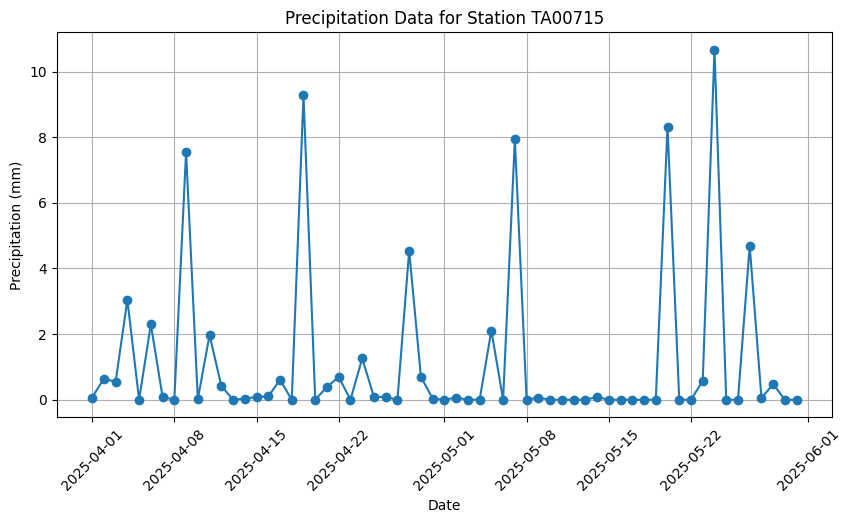

Station Code: TA00715
Data Range: 0.0 mm to 10.663 mm
Number of Records: 61


In [111]:
# @title Step 3b: Extracting Precipitation data and visualisation
# @markdown Using filter-stations to extract precipitation data <br>

# save to the directory

# print('Extracting Precipitation Data ...')
region_precip = rd.multiple_measurements(stations_list=info['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                         csv_file=f'{dir_path}/tahmo_precip_{region_query}')

# check if the file exist to know if it was successful
if not os.path.exists(f'{dir_path}/tahmo_precip_{region_query}.csv'):
    print("❌ Precipitation data not extracted successfully.")
else:
    print("✅ Precipitation data extracted successfully.")

# Visualise any random station data
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(region_precip)

In [112]:
# @title ### Step 4: Extracting CHIRPS data and visualising the data for the query region

# @markdown Extract the data from Google Earth engine project

# @markdown **Note**: For this workshop, we have done this process for you when we shared the Google Cloud invitation to the project

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(region_geom)

# Extract data for 2020
chirps_ds = get_chirps_pentad_gee(
    start_date=start_date,
    end_date=end_date,
    region=roi,
    export_path=f'{dir_path}/chirps_pentad_{region_query}.nc'
)

# Removing the imputed values resetting to NaN
chirps_ds = chirps_ds.where(chirps_ds != -9999)


plot_xarray_data2(
    xarray_ds=chirps_ds,
    fig_title=f"CHIRPS Precipitation Analysis in {region_query}",
    columns=["precipitation"],
    plot_size=7,
    bbox=[xmin, ymin, xmax, ymax],
    # save=True
)


Total number of images: 12

Exporting 1/12: chirps_temp/20250401.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250401.tif


Exporting 2/12: chirps_temp/20250406.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250406.tif


Exporting 3/12: chirps_temp/20250411.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250411.tif


Exporting 4/12: chirps_temp/20250416.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250416.tif


Exporting 5/12: chirps_temp/20250421.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250421.tif


Exporting 6/12: chirps_temp/20250426.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250426.tif


Exporting 7/12: chirps_temp/20250501.tif
Generating URL ...
Please wait ...
Data downloaded to /content/chirps_temp/20250501.tif


Exporting 8/12: chirps_temp/20250506.tif
Generating URL

## Data Processing
1. Range, missing, and flatline detection (≥ N days with unchanged values).
2. Aggregate station rain to pentads to match CHIRPS.
3. Nearest-pixel extraction from CHIRPS and merge with station pentads.
4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for
bias.
5. Combine into a 0–100 confidence score and classify (High/Medium/Low).

Loading the Extracted TAHMO data and metadata

In [125]:
# @title Step5: Load the CHIRPS and Ground Precipitation and Metadata
import xarray as xr

region_precip_data = pd.read_csv(f'{dir_path}/tahmo_precip_{region_query}.csv')
# eac metadata
region_metadata = pd.read_csv(f"{dir_path}/tahmo_metadata_{region_query}.csv")
region_metadata = region_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset(f'{dir_path}/chirps_pentad_{region_query}.nc')
chirps_ds = chirps_ds.where(chirps_ds != -9999)

# Format the TAHMO data
region_precip_data = region_precip_data.rename(columns={"Unnamed: 0": "Date"})
region_precip_data['Date'] = pd.to_datetime(region_precip_data['Date'])
region_precip_data = region_precip_data.set_index('Date')
region_precip_data.index = region_precip_data.index.tz_localize(None)

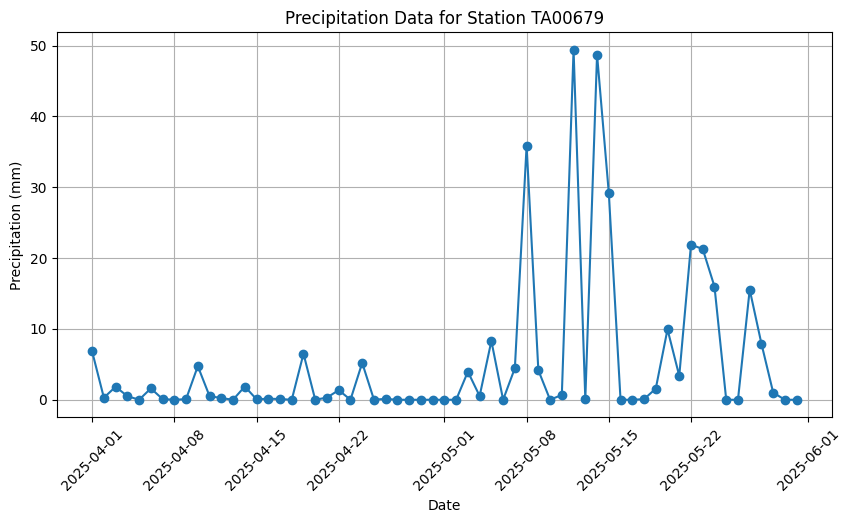

Station Code: TA00679
Data Range: 0.0 mm to 49.407 mm
Number of Records: 61


In [126]:
# @title Step 6a: Check the range of the data and plot any of the stations randomly
# @markdown Rerun to visualise a random station in the region
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(region_precip_data)

Stations with missing data: ['TA00025_S002904', 'TA00025_S002905', 'TA00025_S000116', 'TA00134', 'TA00770', 'TA00771', 'TA00772', 'TA00773', 'TA00774', 'TA00775', 'TD00005']
Stations with missing data: ['TA00025_S002904', 'TA00025_S002905', 'TA00025_S000116']
Stations with missing data: []


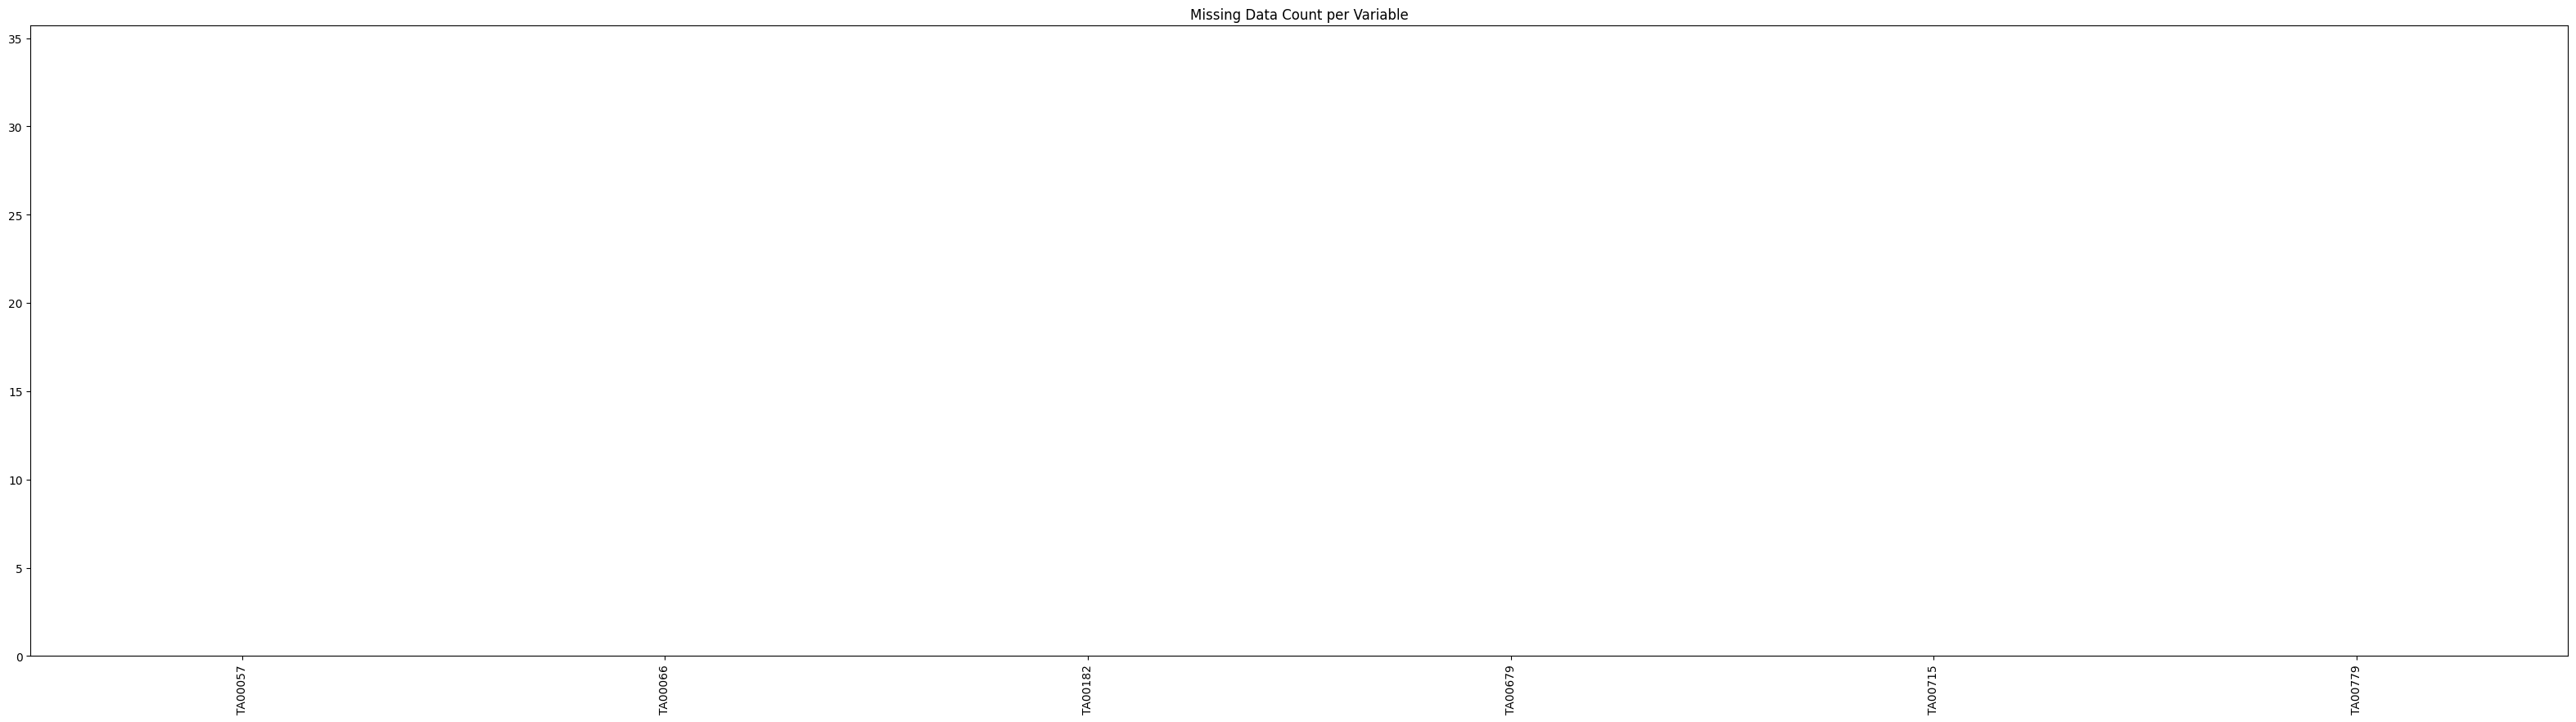

In [128]:
# @title Step 6b: Handling Missing Data
# Get the stations with missing data
missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")
# drop stations with all missing data
region_precip_data = region_precip_data.dropna(how='all', axis=1)
region_precip_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")

# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in region_precip_data.columns if len(i.split('_')) > 1]
region_precip_data = region_precip_data.drop(columns=multiple_sensors)
region_precip_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = region_precip_data.columns[region_precip_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


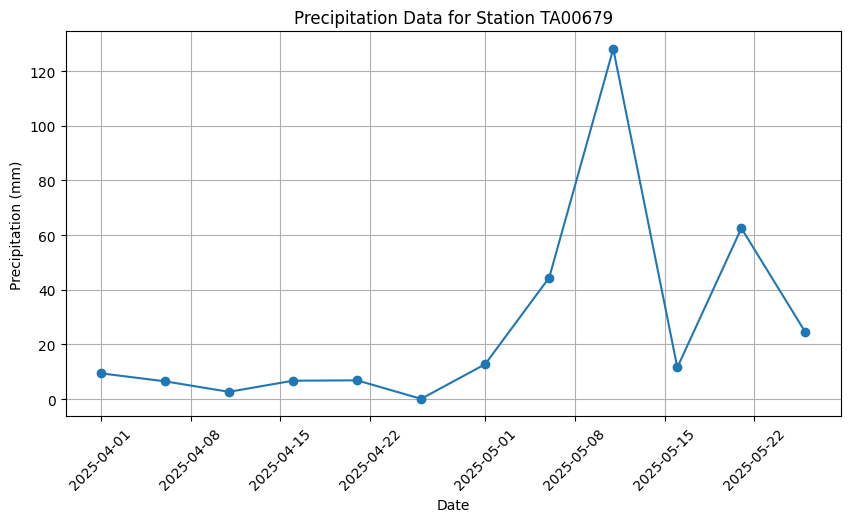

Station Code: TA00679
Data Range: 0.119 mm to 128.107 mm
Number of Records: 12


In [129]:
# @title Step 7: Aggregate station rain to pentads to match CHIRPS.
region_precip_pentad = rd.aggregate_variables(region_precip_data, freq='5D', method='sum')[:-1]
plot_stations_data_randomly(region_precip_pentad)


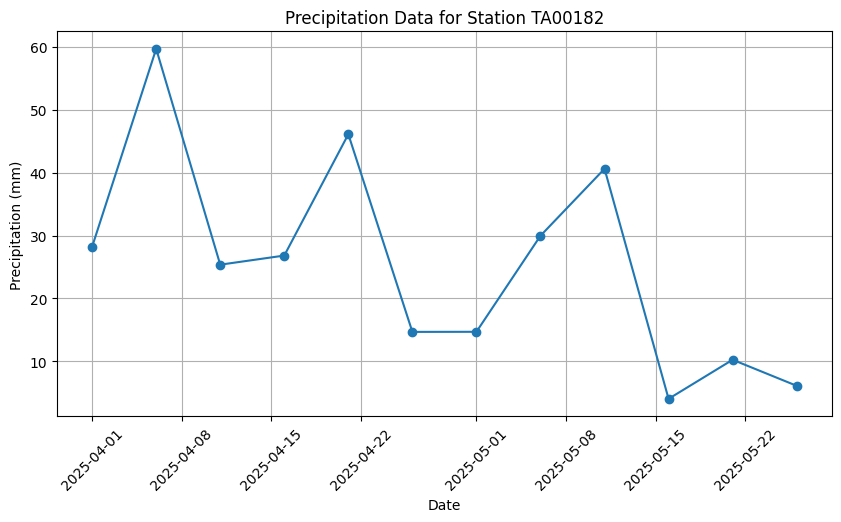

Station Code: TA00182
Data Range: 4.041961669921875 mm to 59.70328140258789 mm
Number of Records: 12


In [131]:
# @title Nearest-pixel extraction from CHIRPS and merge with station pentads.
# filter to the required stations
req_stations = region_precip_pentad.columns.tolist()

region_metadata = region_metadata[region_metadata['code'].isin(req_stations)]

def build_chirps_from_stations(chirps_ds, stations_metadata):
    import xarray as xr
    import pandas as pd

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Extract nearest pixel data
        station_da = chirps_ds.precipitation.sel(x=lon, y=lat, method="nearest")
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    # Combine all stations into a single DataFrame
    combined_df = pd.DataFrame(all_stations_data)
    return combined_df

chirps_stations = build_chirps_from_stations(chirps_ds, region_metadata)
plot_stations_data_randomly(chirps_stations)

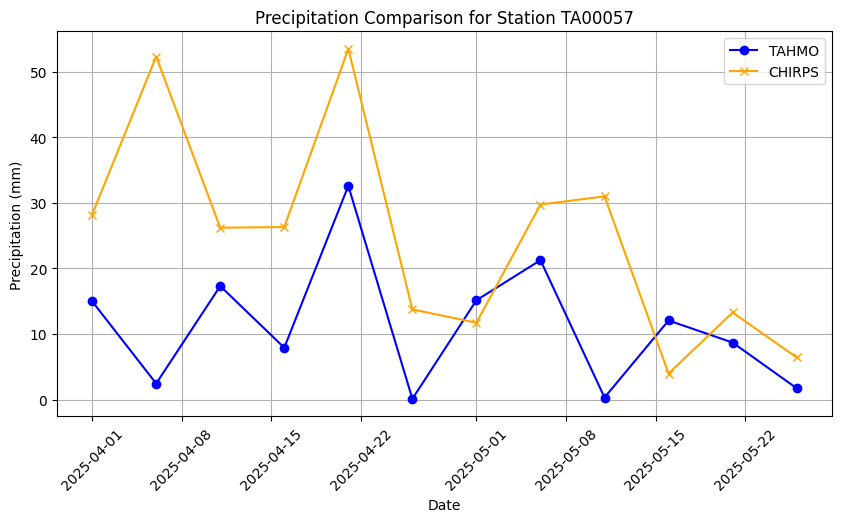

Station Code: TA00057
TAHMO Data Range: 0.119 mm to 32.582 mm
CHIRPS Data Range: 3.965704917907715 mm to 53.454994201660156 mm
Number of TAHMO Records: 12
Number of CHIRPS Records: 12


In [138]:
# @title Plot the CHIRPS data and TAHMO equivalents for a random station
def plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations):
    import random
    station_codes = eac_pentad.columns.intersection(chirps_stations.columns).tolist()
    if not station_codes:
        print("No common stations between EAC pentad data and CHIRPS data.")
        return

    random_station = random.choice(station_codes)

    tahmo_data = eac_pentad[random_station]
    chirps_data = chirps_stations[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(tahmo_data.index, tahmo_data.values, marker='o', label='TAHMO', color='blue')
    plt.plot(chirps_data.index, chirps_data.values, marker='x', label='CHIRPS', color='orange')
    plt.title(f'Precipitation Comparison for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"TAHMO Data Range: {tahmo_data.min()} mm to {tahmo_data.max()} mm")
    print(f"CHIRPS Data Range: {chirps_data.min()} mm to {chirps_data.max()} mm")
    print(f"Number of TAHMO Records: {len(tahmo_data)}")
    print(f"Number of CHIRPS Records: {len(chirps_data)}")

plot_chirps_vs_tahmo_randomly(region_precip_pentad, chirps_stations)

### 4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for bias.

In [139]:
# @title Compute Station Scores
# @markdown The confidence score is computed as confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate)) <br>


def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        # Compute metrics
        r, _ = pearsonr(obs, sim)
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                'pearson_r': r,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

# @title RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))


station_scores = compute_station_scores(region_precip_pentad, chirps_stations)
# to the confidence scores subtract the rmse
station_scores['adjusted_confidence_score'] = station_scores['confidence_score'] - station_scores['rmse']
station_scores.sort_values(by='adjusted_confidence_score', ascending=False).head(20)

# save the stations with the confidence scores
station_scores.to_csv(f'{dir_path}/station_scores_{region_query}.csv', index=False)


'''
1. Compute the RMSE
2. Compute the Pearson correlation coefficient
3. Compute the ttest for bias
    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']
4. Compute completeness (% of non-missing values)
        completeness = 1 - g['station_pentad'].isna().mean()
        outlier_rate = (g['station_pentad']<0).mean()
5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))
'''
station_scores.sort_values(by='confidence_score', ascending=False).head(10)


,station_id,confidence_score,pearson_r,rmse,bias_signif,completeness,outlier_rate,adjusted_confidence_score
2,TA00182,85.303693,0.632592,16.756338,Significant,1.0,0.0,68.547356
1,TA00066,75.253863,0.381347,28.416846,Not Significant,1.0,0.0,46.837017
0,TA00057,74.486762,0.362169,20.059050,Significant,1.0,0.0,54.427712
5,TA00779,71.943732,0.298593,33.258008,Significant,1.0,0.0,38.685724
3,TA00679,65.167012,0.129175,40.035182,Not Significant,1.0,0.0,25.131830
4,TA00715,54.617105,-0.134572,32.649337,Significant,1.0,0.0,21.967767


In [ ]:
# @title plot stations vs chirps
def plot_station_vs_chirps_and_confidence(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    figsize_scatter=(6,5),
    figsize_map=(6,5)
):
    """
    Create:
      1) Scatter of all paired station pentad vs CHIRPS pentad values.
      2) Map of station confidence classes (High/Medium/Low).
    Parameters
    ----------
    station_pentad_df : DataFrame
        Aggregated station pentad totals (index = datetime, columns = station_id).
    chirps_pentad_df : DataFrame
        CHIRPS pentad precipitation extracted at station locations
        (same index + overlapping columns).
    station_scores_df : DataFrame
        Output of compute_station_scores (needs columns: station_id, confidence_score).
    metadata_df : DataFrame
        Must contain columns: code, lat, lon.
    country_label : str
        Title label.
    high_thr : float
        Threshold (inclusive upper) for High classification.
    low_thr : float
        Threshold upper bound for Low. Medium is (low_thr, high_thr).
    min_pairs : int
        Minimum valid (non-nan) pairs required to include a station in scatter.
    """
    # -----------------------------
    # 1. Build long paired dataset
    # -----------------------------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    all_rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame(
            {
                'station_pentad': s_obs,
                'sat_pentad': s_sat
            }
        ).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            all_rows.append(pair)
    if not all_rows:
        print("No stations with sufficient paired data.")
        return
    m = pd.concat(all_rows, axis=0)

    # 2. Classify confidence
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify)

    # 3. Merge with metadata
    meta = metadata_df.rename(columns={'code': 'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left')

    # 4. Scatter: station vs CHIRPS
    plt.figure(figsize=figsize_scatter)
    plt.scatter(m['station_pentad'], m['sat_pentad'], s=14, alpha=0.55, edgecolor='none')
    # 1:1 line
    lim_max = max(m['station_pentad'].max(), m['sat_pentad'].max())
    plt.plot([0, lim_max], [0, lim_max], 'k--', linewidth=1)
    plt.xlabel('Station Pentad (mm)')
    plt.ylabel('CHIRPS Pentad (mm)')
    plt.title(f"{country_label}: Station vs CHIRPS (Pentad)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 5. Confidence class map
    # -----------------------------
    plt.figure(figsize=figsize_map)
    for cls, color in zip(['High','Medium','Low'], ['green','orange','red']):
        sel = score_map[score_map['class'] == cls]
        if not sel.empty:
            plt.scatter(sel['lon'], sel['lat'], label=cls, s=32, c=color, alpha=0.8)
    plt.legend(title='Confidence')
    plt.title(f"{country_label} Station Confidence Classes")
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return m, score_map

# m_pairs, score_with_meta = plot_station_vs_chirps_and_confidence(
#     eac_pentad,           # station pentad dataframe
#     chirps_stations,      # CHIRPS-at-stations pentad dataframe
#     station_scores,       # scores dataframe
#     eac_metadata,         # metadata with code, lat, lon
#     country_label="EAC (Kenya/Uganda/Rwanda)"
# )

In [141]:
# @title Setting the threshold for high and low

import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

def plot_station_vs_chirps_and_confidence_interactive(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    scatter_color="#3366cc"
):
    """
    Scatter: single color (no category legend)
    Geo map: always shows High / Medium / Low categories
    Returns:
      m_long, score_map, scatter_fig, map_fig
    """
    # -------- 1. Build long paired dataset --------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame({'station_pentad': s_obs, 'sat_pentad': s_sat}).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            rows.append(pair)
    if not rows:
        print("No stations with sufficient paired data.")
        return None, None, None, None
    m_long = pd.concat(rows, axis=0).reset_index(drop=True)

    # -------- 2. Always compute classification for map --------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify_fn(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify_fn)
    # enforce category ordering even if some missing
    cls_order = ['High','Medium','Low']
    sc['class'] = pd.Categorical(sc['class'], categories=cls_order, ordered=True)

    # -------- 3. Merge with metadata --------
    meta = metadata_df.rename(columns={'code':'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left').dropna(subset=['lat','lon'])
    score_map['class'] = pd.Categorical(score_map['class'], categories=cls_order, ordered=True)

    # -------- 4. Merge scores into long paired --------
    merge_cols = ['station_id','confidence_score','class','pearson_r','rmse','completeness','outlier_rate','bias_signif']
    existing = [c for c in merge_cols if c in sc.columns]
    m_long = m_long.merge(sc[existing], on='station_id', how='left')

    # -------- 5. Scatter (single color) --------
    lim_max = float(max(m_long['station_pentad'].max(), m_long['sat_pentad'].max()))
    hover_data = {
        'station_id': True,
        'time': True,
        'station_pentad': ':.2f',
        'sat_pentad': ':.2f',
        'confidence_score': ':.1f',
        'class': True,
        'pearson_r': ':.3f',
        'rmse': ':.2f',
        'completeness': ':.2f',
        'outlier_rate': ':.3f',
        'bias_signif': True
    }
    scatter_fig = px.scatter(
        m_long,
        x='station_pentad',
        y='sat_pentad',
        title=f"{country_label}: Station vs CHIRPS (Pentad)",
        hover_data=hover_data,
        labels={'station_pentad':'Station (mm)','sat_pentad':'CHIRPS (mm)'}
    )
    scatter_fig.update_traces(marker=dict(color=scatter_color))
    scatter_fig.update_layout(showlegend=False)
    scatter_fig.add_trace(
        go.Scatter(
            x=[0, lim_max],
            y=[0, lim_max],
            mode='lines',
            line=dict(dash='dash', color='black'),
            name='1:1'
        )
    )
    scatter_fig.update_xaxes(constrain='domain')
    scatter_fig.update_yaxes(scaleanchor=None)

        # -------- 6. Geo Map (with categories, OSM basemap) --------
    palette = {'High':'green','Medium':'orange','Low':'red'}
    map_fig = px.scatter_mapbox(
        score_map,
        lat='lat',
        lon='lon',
        color='class',
        color_discrete_map=palette,
        hover_name='station_id',
        hover_data={
            'confidence_score': ':.1f',
            'pearson_r': ':.3f',
            'rmse': ':.2f',
            'completeness': ':.2f',
            'outlier_rate': ':.3f',
            'bias_signif': True,
            'lat': ':.3f',
            'lon': ':.3f'
        },
        title=f"{country_label} Station Confidence",
        zoom=5,
        height=600
    )
    # map_fig.update_layout(
    #     legend_title_text='Confidence',
    #     mapbox_style="open-street-map"
    # )
    map_fig.update_layout(
        mapbox_style="open-street-map",
        legend_title_text=f"Confidence<br>(High ≥ {high_thr}, Low ≥ {low_thr})"
    )

    if {'lat','lon'}.issubset(score_map.columns) and len(score_map):
        lat_min, lat_max = score_map['lat'].min(), score_map['lat'].max()
        lon_min, lon_max = score_map['lon'].min(), score_map['lon'].max()
        lat_center = (lat_min + lat_max) / 2
        lon_center = (lon_min + lon_max) / 2
        map_fig.update_layout(
            mapbox_center={"lat": lat_center, "lon": lon_center},
            mapbox_zoom=5
        )


    return m_long, score_map, scatter_fig, map_fig

# Get the user to input the high and low threshold
high_thr = int(input("Enter the high threshold (default 70): ") or 70)
low_thr = int(input("Enter the low threshold (default 40): ") or 40)
print(f"High threshold: {high_thr}")
print(f"Low threshold: {low_thr}")
time.sleep(2)

m_pairs, score_with_meta, scatter_fig, map_fig = plot_station_vs_chirps_and_confidence_interactive(
    region_precip_pentad,
    chirps_stations,
    station_scores,
    region_metadata,
    country_label=f"{region_query}",
    high_thr=high_thr,
    low_thr=low_thr,
    scatter_color="#3366cc"
)

if scatter_fig is not None:
    scatter_fig.show()
    map_fig.show()


Enter the high threshold (default 70): 70
Enter the low threshold (default 40): 40
High threshold: 70
Low threshold: 40


In [ ]:
# @title Widget plotting

import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go

# --- Flatline detection (unchanged) ---
def detect_flatlines_window(data, window_size=5):
    flatline_info = {}
    for station in data.columns:
        rolling_std = data[station].rolling(window=window_size).std()
        ends = rolling_std[rolling_std == 0].index.tolist()
        if ends:
            flatline_info[station] = ends
    return flatline_info

def _flat_segments(series, ends, window_size):
    if not ends:
        return []
    mask = pd.Series(False, index=series.index)
    for end in ends:
        start = end - pd.Timedelta(days=window_size - 1)
        span = (series.index >= start) & (series.index <= end)
        mask |= span
    flat_idx = series.index[mask]
    if len(flat_idx) == 0:
        return []
    groups = (flat_idx.to_series().diff() > pd.Timedelta(days=1)).cumsum()
    segs = [seg for _, seg in flat_idx.to_series().groupby(groups)]
    return segs

def plot_station_flatlines(data, station, flatline_info, window_size):
    series = data[station].copy()
    fig = go.Figure()
    fig.add_scatter(
        x=series.index, y=series.values,
        mode="lines+markers",
        name="Values",
        line=dict(color="#888", width=1),
        marker=dict(size=6, color="#555"),
        hovertemplate="Date=%{x|%Y-%m-%d}<br>Value=%{y:.2f}<extra></extra>"
    )
    if station in flatline_info:
        segs = _flat_segments(series, flatline_info[station], window_size)
        for i, seg in enumerate(segs):
            fig.add_scatter(
                x=seg,
                y=series.loc[seg],
                mode="lines+markers",
                name="Flatline",
                line=dict(color="red", width=4),
                marker=dict(size=7, color="white", line=dict(color="red", width=2)),
                hovertemplate="Date=%{x|%Y-%m-%d}<br>Flat Value=%{y:.2f}<extra></extra>",
                showlegend=(i == 0)
            )
    miss_prop = series.isna().mean()
    missing = series.isna().sum()
    total = len(series)
    flat_ct = len(flatline_info.get(station, []))
    fig.update_layout(
        title=f"Station {station} (Flatline window={window_size}d)",
        xaxis_title="Date",
        yaxis_title="Precipitation (mm)",
        height=360,
        legend=dict(orientation="h", y=1.02),
        margin=dict(l=40, r=10, t=60, b=40)
    )
    fig.add_annotation(
        text=f"Missing: {missing}/{total} ({miss_prop:.1%}) | Flat windows ends: {flat_ct}",
        xref="paper", yref="paper", x=0, y=1.10, showarrow=False, font=dict(size=11)
    )
    return fig

def plot_station_sat_timeseries(m_pairs, station):
    df = m_pairs[m_pairs.station_id == station].sort_values('time')
    if df.empty:
        return go.Figure().add_annotation(text="No pentad match data.", x=0.5, y=0.5, showarrow=False)
    fig = go.Figure()
    fig.add_scatter(
        x=df.time, y=df.station_pentad,
        mode="lines+markers",
        name="Station pentad",
        line=dict(color="#1f77b4"),
        marker=dict(size=6),
        hovertemplate="Pentad=%{x|%Y-%m-%d}<br>Station=%{y:.2f}<extra></extra>"
    )
    fig.add_scatter(
        x=df.time, y=df.sat_pentad,
        mode="lines+markers",
        name="CHIRPS pentad",
        line=dict(color="#ff7f0e"),
        marker=dict(size=6),
        hovertemplate="Pentad=%{x|%Y-%m-%d}<br>CHIRPS=%{y:.2f}<extra></extra>"
    )
    fig.update_layout(
        title=f"Pentad Comparison {station}",
        xaxis_title="Pentad start",
        yaxis_title="Precip (mm)",
        height=360,
        legend=dict(orientation="h", y=1.02),
        margin=dict(l=40, r=10, t=60, b=40)
    )
    return fig

# --- Helper to build adjusted score map ---
def build_adjusted_map(df, low, high):
    df = df.copy()
    def classify(v):
        if v >= high: return "High"
        if v >= low: return "Medium"
        return "Low"
    df["adjusted_class_new"] = df["adjusted_confidence_score"].apply(classify)
    colors = {"High": "green", "Medium": "orange", "Low": "red"}
    fig = go.Figure()
    for cls in ["High", "Medium", "Low"]:
        sub = df[df.adjusted_class_new == cls]
        if sub.empty:
            continue
        fig.add_scattergeo(
            lon=sub.lon,
            lat=sub.lat,
            text=sub.station_id,
            hovertext=sub.station_id,
            customdata=sub[["adjusted_confidence_score","confidence_score","pearson_r","rmse","completeness","outlier_rate"]],
            hovertemplate=(
                "<b>%{hovertext}</b><br>"
                "Adj score=%{customdata[0]:.1f}<br>"
                "Orig score=%{customdata[1]:.1f}<br>"
                "r=%{customdata[2]:.2f}<br>"
                "RMSE=%{customdata[3]:.1f}<br>"
                "Compl=%{customdata[4]:.2f}<br>"
                "Outliers=%{customdata[5]:.2f}<extra></extra>"
            ),
            mode="markers",
            marker=dict(color=colors[cls], symbol="circle", size=8),
            name=cls
        )
    fig.update_layout(
        title=f"Adjusted Confidence (Low={low}, High={high})",
        geo=dict(showland=True, landcolor="#EEEEEE", showcountries=True, fitbounds="locations"),
        legend_title="Adjusted Class",
        height=420,
        margin=dict(l=20,r=10,t=50,b=10)
    )
    return fig

# --- Shared controls (classification thresholds) on Page 1 ---
low_slider = widgets.IntSlider(value=low_slider.value if 'low_slider' in globals() else 40,
                               min=0, max=90, step=5, description='Low thr', continuous_update=False)
high_slider = widgets.IntSlider(value=high_slider.value if 'high_slider' in globals() else 70,
                                min=10, max=100, step=5, description='High thr', continuous_update=False)
show_adjusted_map_chk = widgets.Checkbox(description="Show adjusted score map", value=False)

# --- Page 1 widgets (overview) ---
refresh_overview_btn = widgets.Button(description='Update Overview', button_style='primary', icon='refresh')
output_overview = widgets.Output()
output_map = widgets.Output()
output_map_adjusted = widgets.Output()
output_scatter = widgets.Output()
output_sample_scores = widgets.Output()

# --- Page 2 widgets (station detail) ---
station_dropdown = widgets.Dropdown(options=sorted(eac_data.columns), description='Station', layout=widgets.Layout(width='240px'))
window_slider = widgets.IntSlider(value=5, min=3, max=20, step=1, description='Flat win', continuous_update=False)
missing_warn_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Max miss%', readout_format='.0%', continuous_update=False)
refresh_station_btn = widgets.Button(description='Update Station', icon='refresh')
output_station = widgets.Output()
output_station_comp = widgets.Output()

_current_flatlines_cache = {}

def refresh_overview(_=None):
    low = low_slider.value
    high = high_slider.value
    if low >= high:
        low_slider.value = max(0, high - 10)
        low = low_slider.value
    sc = station_scores.copy()

    # New classification on original confidence_score
    def classify(v):
        if v >= high: return 'High'
        if v >= low:  return 'Medium'
        return 'Low'
    sc['class_new'] = sc['confidence_score'].apply(classify)

    with output_overview:
        clear_output(wait=True)
        print("Reclassification counts:")
        display(sc['class_new'].value_counts())

    # Original map & scatter via existing function
    with output_map:
        clear_output(wait=True)
        try:
            _, score_map_new, scatter_fig_new, map_fig_new = plot_station_vs_chirps_and_confidence_interactive(
                eac_pentad,
                chirps_stations,
                station_scores,
                eac_metadata,
                country_label="EAC (Kenya/Uganda/Rwanda)",
                high_thr=high_slider.value,
                low_thr=low_slider.value,
                scatter_color="#3366cc"
            )
            if map_fig_new:
                display(map_fig_new)
        except Exception as exc:
            print("Map generation failed:", exc)
            scatter_fig_new = None

    # Adjusted map (conditional)
    with output_map_adjusted:
        clear_output(wait=True)
        if show_adjusted_map_chk.value:
            try:
                fig_adj = build_adjusted_map(score_with_meta, low, high)
                display(fig_adj)
            except Exception as exc:
                print("Adjusted map failed:", exc)

    # Scatter
    with output_scatter:
        clear_output(wait=True)
        if scatter_fig_new:
            display(scatter_fig_new)

    # Table (fix: no duplicate merge)
    with output_sample_scores:
        clear_output(wait=True)
        try:
            cols = ['station_id','confidence_score','pearson_r','rmse','completeness','outlier_rate','class','class_new']
            # Ensure columns exist
            present = [c for c in cols if c in sc.columns]
            print("Score table (first 15):")
            display(sc[present].head(15))
        except Exception as exc:
            print("Table failed:", exc)

def refresh_station(_=None):
    st = station_dropdown.value
    w = window_slider.value
    low = low_slider.value
    high = high_slider.value
    if low >= high:
        high_slider.value = min(100, low + 10)
    key = f"w{w}"
    if key not in _current_flatlines_cache:
        _current_flatlines_cache[key] = detect_flatlines_window(eac_data, window_size=w)
    flats = _current_flatlines_cache[key]
    with output_station:
        clear_output(wait=True)
        try:
            fig = plot_station_flatlines(eac_data, st, flats, w)
            display(fig)
            miss_prop = eac_data[st].isna().mean()
            if miss_prop > missing_warn_slider.value:
                print(f"WARNING: Missing proportion {miss_prop:.1%} exceeds {missing_warn_slider.value:.0%}")
        except Exception as exc:
            print("Flatline plot failed:", exc)
    with output_station_comp:
        clear_output(wait=True)
        try:
            fig2 = plot_station_sat_timeseries(m_pairs, st)
            display(fig2)
        except Exception as exc:
            print("Comparison plot failed:", exc)

# Events
refresh_overview_btn.on_click(refresh_overview)
show_adjusted_map_chk.observe(refresh_overview, names='value')
refresh_station_btn.on_click(refresh_station)
station_dropdown.observe(refresh_station, names='value')
window_slider.observe(refresh_station, names='value')

# --- Layout Page 1 (Map -> Optional Adjusted Map -> Scatter -> Table) ---
page1_controls = widgets.HBox([low_slider, high_slider, show_adjusted_map_chk, refresh_overview_btn])
page1_box = widgets.VBox([
    widgets.HTML("<b>Overview: Scatter & Map</b>"),
    page1_controls,
    output_map,
    output_map_adjusted,
    output_scatter,
    output_sample_scores
])

# --- Layout Page 2 ---
page2_controls = widgets.HBox([station_dropdown, window_slider, missing_warn_slider, refresh_station_btn])
page2_box = widgets.VBox([
    widgets.HTML("<b>Station Detail: Flatlines & CHIRPS Comparison</b>"),
    page2_controls,
    output_station,
    widgets.HTML("<b>Pentad Station vs CHIRPS</b>"),
    output_station_comp
])

tabs = widgets.Tab(children=[page1_box, page2_box])
tabs.set_title(0, "Overview")
tabs.set_title(1, "Station Detail")
display(tabs)

# Initial draws
refresh_overview()
refresh_station()
